# Environment Setting

Step 1: upload entire "Structure Product (combined ver.)" folder to google drive\
Step 2: run the first code box below to mount to your google drive\
Step 3: paste the google drive path to "filepath = " below\
Step 4: click "Run all" and find output in "Output.xslx" in google drive\

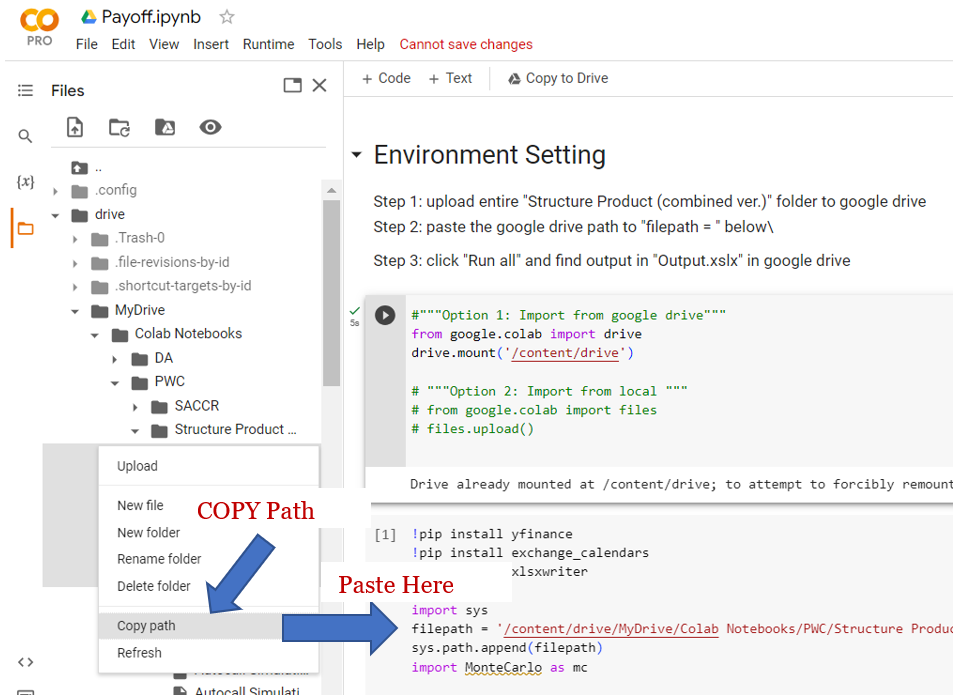

In [3]:

#"""Option 1: Import from google drive"""
### Mount to google drive ###
from google.colab import drive
drive.mount('/content/drive')

# """Option 2: Import from local """
# from google.colab import files
# files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install yfinance
!pip install exchange_calendars
!pip install xlsxwriter

import sys
filepath = '/content/drive/MyDrive/Colab Notebooks/PWC/Structure Product Valuation/Structure Product (separated ver.)/'
sys.path.append(filepath)
import MonteCarlo as mc


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import exchange_calendars as xcals
import datetime as dt
import time
import openpyxl
import random
import os
from openpyxl.drawing.image import Image

#Payoff Calculation

**Call Event:** Occurs when Closing Price of the Underlying on Valuation Date is greater than or equal to the strike.

At maturity, investors will receive 100% Notional Amount plus applicable coupon: \
**Call condition met**. Coupon = Notional Amount x Coupon 1 x Day Count/FXc \
**Otherwise**. Coupon = Notional Amount x Coupon 2 x Day Count/FXc

Pay Counterparty:
Notional Amount x Floating Rate 1 x Act/360 / FXc


In [8]:
def sea_payoff(info,n_simulation = 100000,rf =.00):
  t0 = time.time()
  ticker = [info['tickers']]
  # get historical stock prices for simulation
  price_df = mc.get_stock_price(ticker,info['his_data_start'],info['his_data_end'])
  # load initial price and calculate strike price
  S0 = mc.get_stock_price(ticker,info['trade_date'],info['trade_date']+dt.timedelta(days=1) )
  strike_price = (S0 * info['strike']).values

  # build calender
  xhkg = xcals.get_calendar("XHKG")
  # business date
  bd = xhkg.sessions_in_range(info['trade_date'], info['maturity_date'])
  T = len(bd) #length of simulation

  # valuation date
  valuation_date = info['valuation_date']
  while valuation_date not in bd:
    # If not scheduled trading date, the next following scheduled trading day
    valuation_date = valuation_date+dt.timedelta(days=1)

  # Run simulation
  rt_0 = time.time()
  simu_df = mc.single_asset_simulation(T,price_df,rf,n_simulation,S0)
  print("Runtime for", n_simulation, "simulations is: ", time.time()-rt_0)

  # Calculate called coupon
  valuation_idx = bd.get_loc(valuation_date)
  strike_record = simu_df[valuation_idx,:] >= strike_price
  print(strike_record.sum())
  #### Calculate Payoff ####
  day_count_basis = info['day_count_basis']
  deposit_amount = info['deposit_amount']
  coupon_day_count = (info['maturity_date'] - info['trade_date']).days

  # Payoffs for strike event
  strike_payoff = strike_record*coupon_day_count/day_count_basis * info['coupon_1']*deposit_amount

  # Payoffs for below strike
  below_strike_payoff = (1-strike_record)*coupon_day_count/day_count_basis*info['coupon_2']*deposit_amount

  pay_counterparty =  coupon_day_count /day_count_basis * info['floating_rate']*deposit_amount
  discount_fac = mc.discount_rate(coupon_day_count,rf,day_count_basis)

  coupon_earning = (strike_payoff + below_strike_payoff)* discount_fac
  pnl =  (strike_payoff + below_strike_payoff - pay_counterparty)* discount_fac

  print("Total Runtime：", time.time()-t0)
  return coupon_earning, pnl, simu_df, price_df


# Write Output

In [9]:
def write_output(info, coupon_earning, pnl, simu_df,his_price, n_simulation,output_file):
  # write evaluation results to output file
  deposit_amount = info['deposit_amount']
  output_df = pd.DataFrame(columns = ['A'])

  output_df.loc['tickers'] = info['tickers']
  output_df.loc['referencing period'] = info['his_data_start'].strftime("%m/%d/%Y")+"-"+info['his_data_end'].strftime("%m/%d/%Y")
  output_df.loc['historical volatility'] = mc.get_volatility(his_price).values
  output_df.loc['simulated avg volatility'] = np.mean(mc.get_volatility(simu_df))
  output_df.loc['risk free rate'] = info['risk_free']
  output_df.loc['deposit amount'] = info['deposit_amount']
  output_df.loc['simulation'] = n_simulation
  output_df.loc['potential payoff'] = np.mean(coupon_earning)
  output_df.loc['potential P&L'] = np.mean(pnl)
  output_df.loc['maximum loss'] = np.min(pnl)
  output_df.loc['maximum profit'] = np.max(pnl)
  output_df['B'] = [" "]*7+(output_df.iloc[7:,0].values/deposit_amount).tolist()

  # # print plot
  plt.figure(figsize=(10,9))
  plt.subplot(2,2,1)
  mc.print_stock_plot(info['tickers'],his_price,"Historical Stock Path")
  plt.xticks(rotation = 15)
  plt.subplot(2,2,2)
  final_price = simu_df[-1,:]
  plt.hist(final_price,bins =50,color = 'orange')
  plt.axvline(simu_df[0,0], label = "Initial Price", linestyle="--",color = 'k')
  plt.axvline(np.mean(final_price), label = "Mean Final Price", linestyle="--",color = 'r')
  plt.title("Stimulated Stock Price on Valuation Date")
  plt.legend()
  plt.subplot(2,2,3)
  plt.hist(pnl.T)
  plt.gca().set(title='P&L Frequency Histogram', ylabel='Frequency',xlabel='P&L');
  plt.subplot(2,2,4)
  simu_price_avg = np.mean(simu_df,axis = 1)
  mc.print_stock_plot(info['tickers'],simu_price_avg,"Simulated path (avg)")
  p1 = plt.savefig("myplot.png", dpi = 60)

  strike_price = (simu_df[0,0] * info['strike'])
  valuation_idx = (info['valuation_date']-info['trade_date']).days
  # print randomly selected simulated paths
  plt.figure(figsize=(10,9))
  random_path = random.sample(range(n_simulation),4)
  for i in range(4):
    plt.subplot(2,2,i+1)
    mc.print_stock_plot(info['tickers'],simu_df[:,random_path[i]].T,\
                        "Randomly Selected Paths: No."+str(random_path[i]),\
                        hori_line = [strike_price],hori_label = ['strike barrier'])#,\
                        #verti_line = [valuation_idx],verti_label = ['valuation date'])
  p2 = plt.savefig("myplot2.png", dpi = 60)
  p1 = Image("myplot.png")
  p2 = Image("myplot2.png")

  return output_df,p1,p2

# Run Inputted Contract

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Runtime for 100000 simulations is:  1.8858966827392578
42474
Total Runtime： 3.109034299850464
                                              A         B
tickers                                 3188.HK          
referencing period        02/11/2021-02/11/2022          
historical volatility                  0.213608          
simulated avg volatility               0.213338          
risk free rate                             0.01          
deposit amount                          4210000          
simulation                               100000          
potential payoff                   84072.909123   0.01997
potential P&L                     -49813.171072 -0.011832
maximum loss                     -130659.909587 -0.031036
maximum profit                     59684.156231  0.014177
[*********************100%***********************]  1 of 1 completed
[**

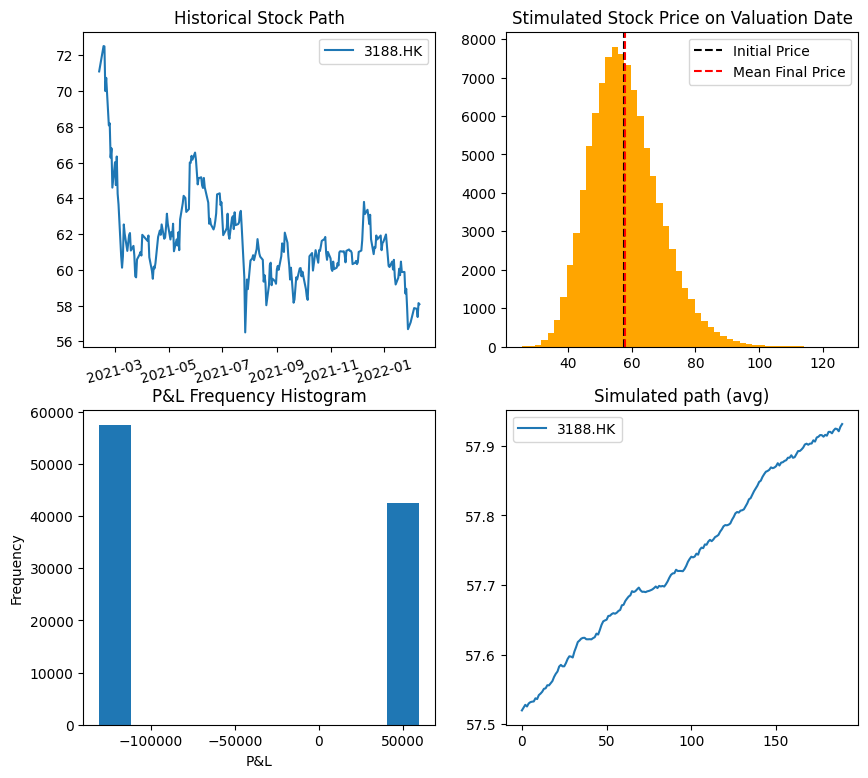

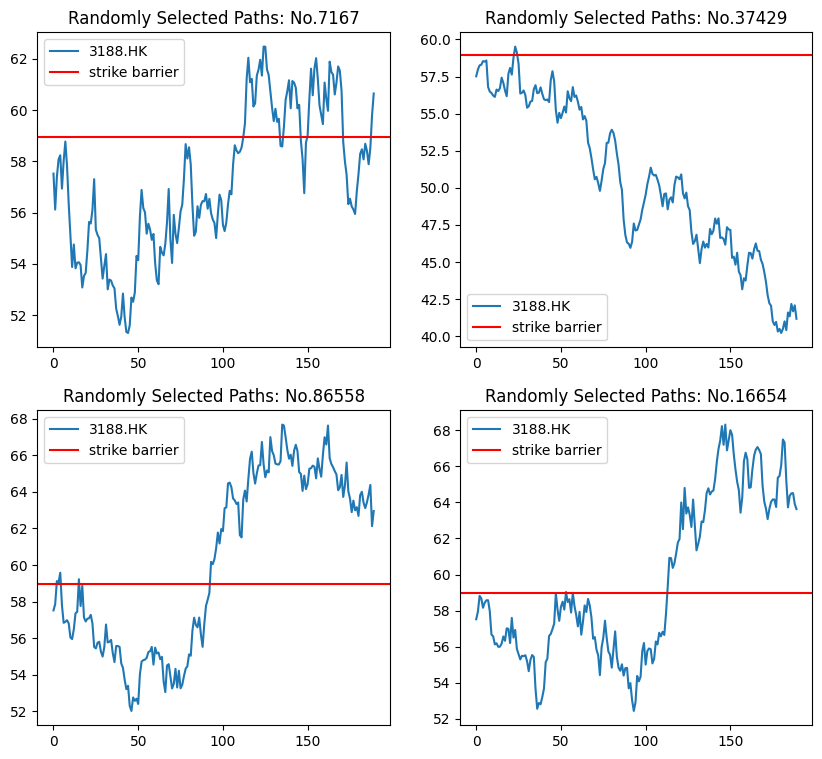

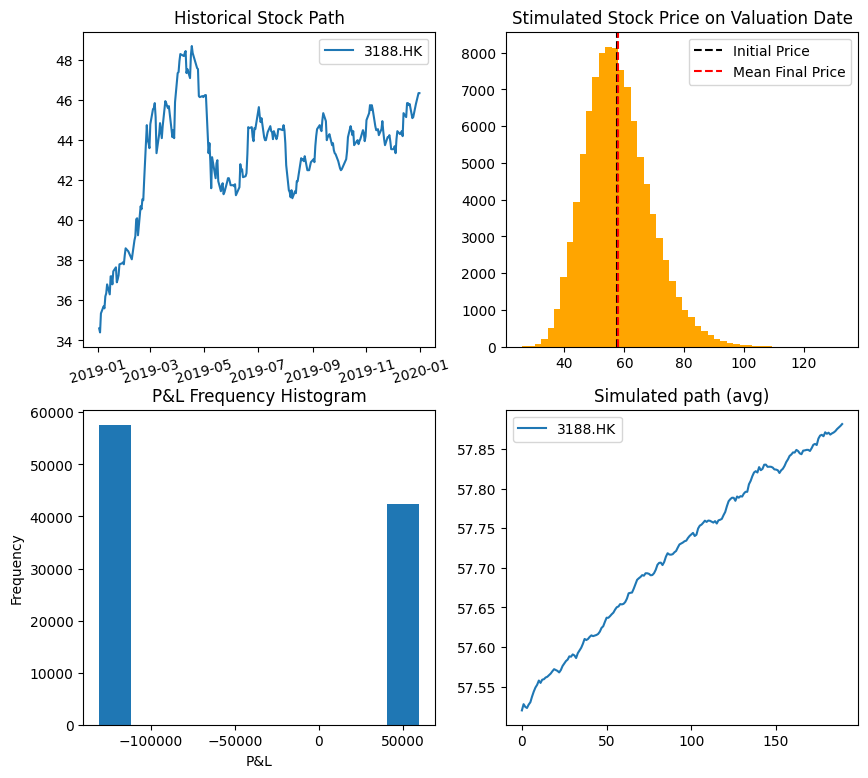

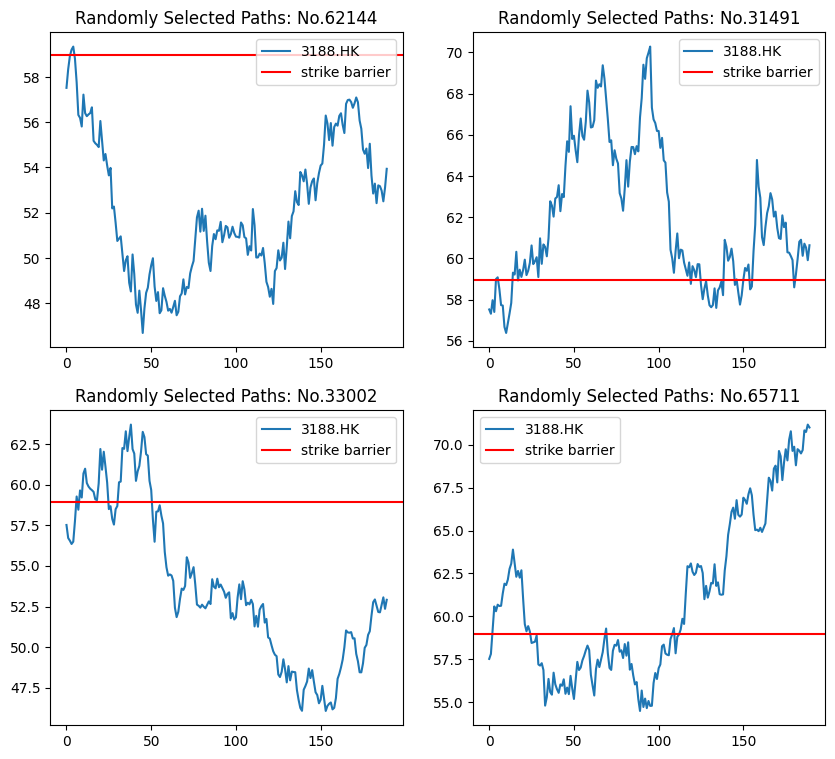

In [10]:
contract_df = pd.read_excel(filepath+'Input.xlsx',sheet_name='Single_Equity_Autocall')
contract = contract_df.to_dict('records')
n_record = len(contract)

# Create output file if it is not in the path
output_filepath = filepath + 'Output.xlsx'
if not os.path.isfile(output_filepath):
  wb = openpyxl.Workbook()
  wb.save(output_filepath)

# Loop over all contracts
for i in range(n_record):
  n_simulation,rf = contract[i]['n_simulation'],contract[i]['risk_free']

  # Run simulation for each contracts
  coupon_earning, pnl, simu_df,his_price = sea_payoff(contract[i],n_simulation,rf)

  # output_df= write_output(contract[i], coupon_earning, pnl, simu_df, \
  #                         his_price,n_simulation, output_filepath)


  output_df,p1,p2 = write_output(contract[i], coupon_earning, pnl, simu_df,\
                                his_price,n_simulation, output_filepath)
  print(output_df)
  # Load workbook and write result
  wb = openpyxl.load_workbook(output_filepath)
  sheet_name = contract[i]['contract']
  try:
    ws = wb[sheet_name]
  except KeyError:
    ws = wb.create_sheet(sheet_name)

  ws.add_image(p1,'E1')
  ws.add_image(p2,'E30')

  ws.column_dimensions['A'].width = 20
  ws.column_dimensions['B'].width = 20
  ws.column_dimensions['C'].width = 20

  wb.save(output_filepath)

  with pd.ExcelWriter(output_filepath, engine = 'openpyxl',mode="a",if_sheet_exists="overlay") as writer:
    output_df.to_excel(writer,sheet_name = contract[i]['contract'])

